# Inspect GZ2 Dataset

`gz2_hart16.csv` avaliable at https://data.galaxyzoo.org/

In [1]:
import os

import numpy as np
import pandas as pd
import pylab as plt
from astroNN.shared.matplotlib import pylab_style

pylab_style(paper=True)

f_sdss = pd.read_csv("gz2_hart16.csv")
print(f"Length of gz2_hart16.csv: {len(f_sdss)}")

# not all GZ2 galaxies are covered by DECals, deleted those entries if not covered
exists_idx = np.array(
    [os.path.exists(f"gz2_des/{str(i).rjust(6, '0')}.jpg") for i in range(len(f_sdss))]
)
print(f"Number of GZ2-SDSS galaxies missing in DECals: {np.sum(~exists_idx)}")

# cutout non-exist DES galaxies (while covered by SDSS)
f_sdss = f_sdss[exists_idx]

Length of gz2_hart16.csv: 239695
Number of GZ2-SDSS galaxies missing in DECals: 748


In [2]:
f_sdss.columns.values

array(['dr7objid', 'ra', 'dec', 'rastring', 'decstring', 'sample',
       'gz2_class', 'total_classifications', 'total_votes',
       't01_smooth_or_features_a01_smooth_count',
       't01_smooth_or_features_a01_smooth_weight',
       't01_smooth_or_features_a01_smooth_fraction',
       't01_smooth_or_features_a01_smooth_weighted_fraction',
       't01_smooth_or_features_a01_smooth_debiased',
       't01_smooth_or_features_a01_smooth_flag',
       't01_smooth_or_features_a02_features_or_disk_count',
       't01_smooth_or_features_a02_features_or_disk_weight',
       't01_smooth_or_features_a02_features_or_disk_fraction',
       't01_smooth_or_features_a02_features_or_disk_weighted_fraction',
       't01_smooth_or_features_a02_features_or_disk_debiased',
       't01_smooth_or_features_a02_features_or_disk_flag',
       't01_smooth_or_features_a03_star_or_artifact_count',
       't01_smooth_or_features_a03_star_or_artifact_weight',
       't01_smooth_or_features_a03_star_or_artifact_frac

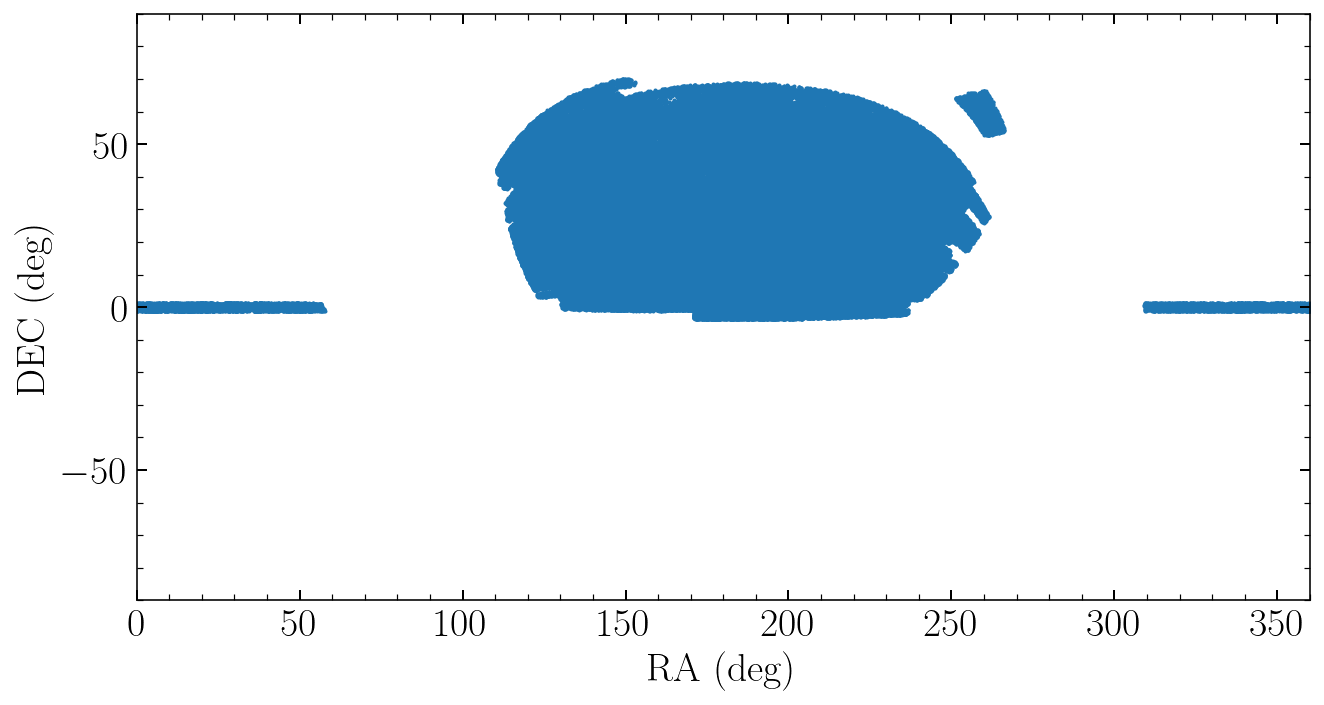

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax.scatter(f_sdss["ra"], f_sdss["dec"], s=1, rasterized=True)
ax.set_xlim(0, 360)
ax.set_ylim(-90, 90)
ax.set_xlabel("RA (deg)")
ax.set_ylabel("DEC (deg)")
ax.set_aspect("equal")
fig.tight_layout()
fig.savefig("figs/gz2_sdss_radec.pdf", bbox_inches="tight")

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.4000e+01,
        4.8000e+01, 1.6400e+02, 4.3700e+02, 1.0090e+03, 2.1920e+03,
        4.3200e+03, 7.2180e+03, 1.1045e+04, 1.5952e+04, 2.1796e+04,
        3.0937e+04, 4.0668e+04, 3.9467e+04, 2.3292e+04, 1.5250e+04,
        9.9120e+03, 6.4520e+03, 3.8970e+03, 2.2790e+03, 1.2230e+03,
        6.7000e+02, 3.6300e+02, 1.9100e+02, 8.5000e+01, 5.3000e+01]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
        26., 28., 30., 32., 34., 36., 38., 40., 42., 44., 46., 48., 50.,
        52., 54., 56., 58., 60., 62., 64., 66., 68., 70.]),
 <BarContainer object of 35 artists>)

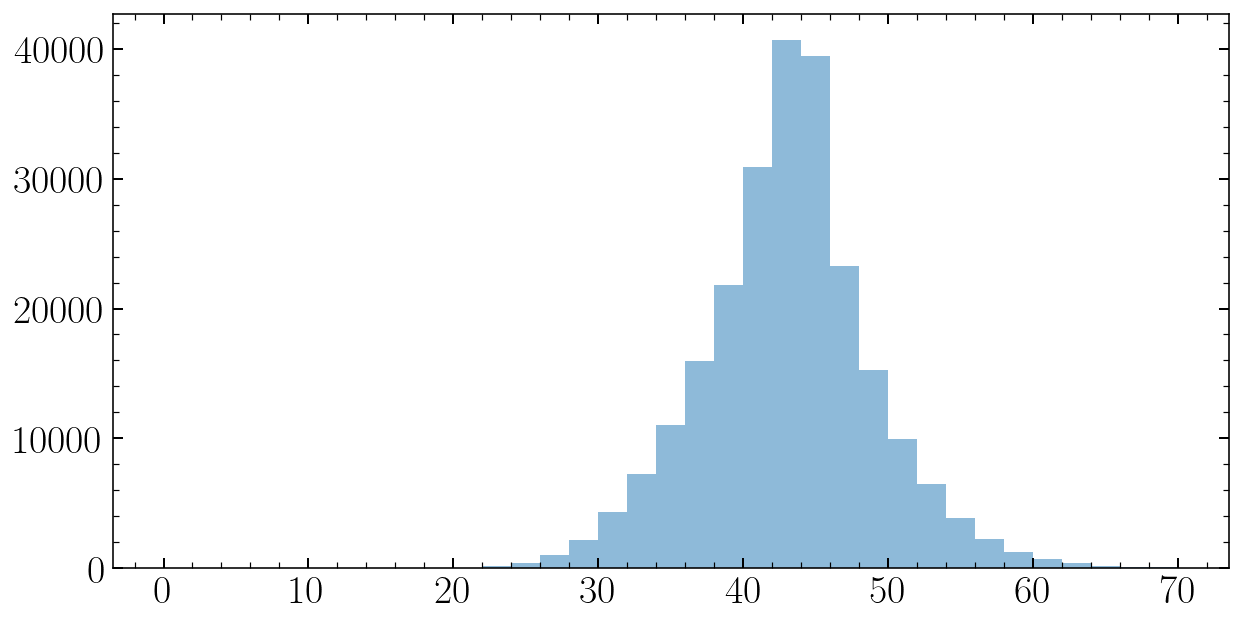

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax.hist(
    f_sdss["t01_smooth_or_features_a01_smooth_count"]
    + f_sdss["t01_smooth_or_features_a02_features_or_disk_count"]
    + f_sdss["t01_smooth_or_features_a03_star_or_artifact_count"],
    range=(0, 70),
    bins=35,
    alpha=0.5,
)

In [4]:
# cross-matching to see if galaxies are in GZ-DES, if not remove them

from astroNN.datasets.xmatch import xmatch

f_ab = pd.read_csv("gz_decals_volunteers_ab.csv")
ra_ab = f_ab["ra"]
dec_ab = f_ab["dec"]

f_c = pd.read_csv("gz_decals_volunteers_c.csv")
ra_c = f_c["ra"][~f_c["in_gzd_ab"]]
dec_c = f_c["dec"][~f_c["in_gzd_ab"]]

ra_abc = np.concatenate([ra_ab.to_numpy(), ra_c.to_numpy()])
dec_abc = np.concatenate([dec_ab.to_numpy(), dec_c.to_numpy()])

idx1, idx2, sep = xmatch(f_sdss["ra"], f_sdss["dec"], ra_abc, dec_abc)

in_gz_des_abc = np.zeros(len(f_sdss), dtype=bool)
in_gz_des_abc[idx1] = True
f_sdss["in_gz_des_abc"] = in_gz_des_abc
f_sdss.to_csv("gz2_hart16_modded.csv")

110964

## Retrieve redshift of SDSS galaxies

The original GZ2 used SDSS DR7 `objid` but seems we have issue to query with SDSS DR7, so we have query DR14 which have different `objid` but then cross-match RA/DEC to get row-matched redshift

In [10]:
import astropy.units as u
import numpy as np
import pandas as pd
import tqdm
from astroNN.datasets import xmatch
from astropy import coordinates as coords
from astropy.table import Table, vstack
from astroquery.sdss import SDSS

f_sdss = pd.read_csv("gz2_hart16_modded.csv")

idx = 0
pos = coords.SkyCoord(
    ra=f_sdss["ra"][idx * 50 : idx * 50 + 50].to_numpy() * u.deg,
    dec=f_sdss["dec"][idx * 50 : idx * 50 + 50].to_numpy() * u.deg,
    frame="icrs",
)
xid = SDSS.query_region(pos, spectro=True)
idx = 1

ra = xid["ra"]
dec = xid["dec"]
objid = xid["objid"]
z = xid["z"]


for i in tqdm.tqdm(range(1, len(f_sdss) // 50 + 1)):
    pos = coords.SkyCoord(
        ra=f_sdss["ra"][idx * 50 : idx * 50 + 50].to_numpy() * u.deg,
        dec=f_sdss["dec"][idx * 50 : idx * 50 + 50].to_numpy() * u.deg,
        frame="icrs",
    )
    _xid = SDSS.query_region(pos, spectro=True)
    ra = np.concatenate([ra, _xid["ra"]])
    dec = np.concatenate([dec, _xid["dec"]])
    objid = np.concatenate([objid, _xid["objid"]])
    z = np.concatenate([z, _xid["z"]])
    idx += 1

idx1, idx2, _ = xmatch(ra, dec, f_sdss["ra"], f_sdss["dec"])

z_sdss = np.ones(len(f_sdss["ra"]))
z_sdss[:] = np.nan
z_sdss[idx2] = z[idx1]

C:\Users\Henry\miniconda3\lib\site-packages\astroquery\sdss\core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4778/4778 [44:29<00:00,  1.79it/s]


In [38]:
# add redshift and save
f_sdss["redshift"] = z_sdss
f_sdss.to_csv("gz2_hart16_modded_z.csv")